### Курсовой проект

1. Обучить модель прогнозирования дохода человека (больше или меньше 50 тыс.долл.) на основе его личных характеристик
2. Создать rest api сервис, к которому можно будет обращаться для получения прогнозов

In [10]:
pip install category_encoders

     |████████████████████████████████| 82 kB 383 kB/s 


In [11]:
pip install flask-ngrok

In [12]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import seaborn as sns
import category_encoders as ce
import dill

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import r2_score as r2, mean_squared_error as mse, roc_auc_score, recall_score

from sklearn import svm
from sklearn.svm import SVR

import statsmodels.api as sm
import statsmodels.formula.api as smf

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Title: База данных UCI взрослых. Предсказать, если доход> или <50 тыс. Долларов США на основе данных переписи

Attributes:
1. age		u  (16,Inf]	# Person's age
2. workclass   u Private Self-emp-not-inc Self-emp-inc Federal-gov  Local-gov State-gov Without-pay Never-worked # Work type
3. fnlwgt      u  [-Inf,Inf]	# ??
4. education   u Preschool 1st-4th 5th-6th 7th-8th 9th 10th 11th 12th HS-grad Assoc-acdm Assoc-voc Some-college Prof-school Bachelors Masters Doctorate # Education level
5. educational-num u [0,Inf] #
6. marital-status  u  Married-civ-spouse Divorced Never-married Separated Widowed Married-spouse-absent Married-AF-spouse	# 
7. occupation  u  Tech-support Craft-repair Other-service Sales Exec-managerial Prof-specialty Handlers-cleaners Machine-op-inspct Adm-clerical Farming-fishing Transport-moving Priv-house-serv Protective-serv Armed-Forces # 
8. relationship u Wife Own-child Husband Not-in-family Other-relative Unmarried	# 
9. race	 u  White Asian-Pac-Islander Amer-Indian-Eskimo Other Black
10. gender	 u  Female Male	# 
11. capital-gain u [0,Inf] #
12. capital-loss u [0,Inf] #
13. hours-per-week u [0,168] #
14. native-country u United-States Cambodia England Puerto-Rico Canada Germany Outlying-US(Guam-USVI-etc) India Japan Greece South China Cuba Iran Honduras Philippines Italy Poland Jamaica Vietnam Mexico Portugal Ireland France Dominican-Republic Laos Ecuador Taiwan Haiti Columbia Hungary Guatemala Nicaragua Scotland Thailand Yugoslavia El-Salvador Trinadad&Tobago Peru Hong Holand-Netherlands #
15. income	   u <=50K >50K # Income breakpoint

## Содержание
* [1. Общее описание датасета](#prep)
* [2. Целевая переменная](#target)
* [3. Признаки](#features)
* [4. Обработка датасета](#prepare)
* [5. Моделирование](#models)
* [6. Pipeline](#pipeline)
* [7. Проверка Pipeline](#check)
* [8. Проверка API Pipeline](#apicheck)


# 1. Общее описание датасета<a class='anchor' id='prep'>

In [13]:
data = '/home/Dataset.data'

In [14]:
df = pd.read_csv(data, sep=' ')

df.columns=["age", "workclass", "fnlwgt", "education", "educational-num", "marital-status", "occupation", "relationship", 
            "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country", "target_50k"]

In [15]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,target_50k
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


Целью работы является построение модели прогнозирование дохода пользователя (больше или меньше 50 тыс долл) в зависимости от его личных параметров. 

Инструментом моделирования служат различные модели машинного обучения:
 - линейная регрессия (в т.ч. с регуляризацией если будет необходимо (при высокой автокорреляции));
 - дерево решений;
 - случайный лес;
 - gradient Boosting;
 - LGBMRegressor;
 - XGBRegressor... . 

Будут рассчитаны различные метрики качества моделей и выбрана наиболее оптимальная.

В качестве проверки будет сделана дополнительная валидационная выборка. 

Далее будет построен pipeline и оценено качество модели на дополнительной подвыборке данных.

Далее будет подготовлено api для возмодности удаленной работы с моделью.


## 2. Целевая переменная<a class='anchor' id='target'>

In [16]:
df.loc[(df['target_50k'] == '<=50K'), 'target_50k'] = 0
df.loc[(df['target_50k'] == '>50K'), 'target_50k'] = 1

In [17]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,target_50k
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0


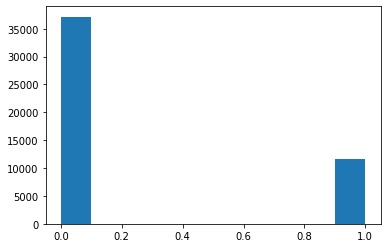

кол-во пропущенных значений 0


In [18]:
plt.hist(df['target_50k'], bins=None)
plt.show()
print('кол-во пропущенных значений', df['target_50k'].isnull().sum())

**Выводы:**

Имеется несбалансированность, при моделировании необходимо это учесть

## 3. Признаки<a class='anchor' id='features'>

In [19]:
df["age"].dtypes
#оставляем, потребуется стандартизация

dtype('int64')

In [20]:
df["workclass"].unique()
#кодируем auto-encoder

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [21]:
df["education"].unique()
#удаляем, как переменную используем следующей столбец

array(['HS-grad', 'Assoc-acdm', 'Some-college', '10th', 'Prof-school',
       '7th-8th', 'Bachelors', 'Masters', 'Doctorate', '11th', '5th-6th',
       'Assoc-voc', '9th', '12th', '1st-4th', 'Preschool'], dtype=object)

In [22]:
df["educational-num"].unique()
#связан с предыдущим, чем лучше образование, там больший рейтинг

array([ 9, 12, 10,  6, 15,  4, 13, 14, 16,  7,  3, 11,  5,  8,  2,  1])

In [23]:
df["marital-status"].unique()
#кодируем auto-encoder

array(['Married-civ-spouse', 'Never-married', 'Widowed', 'Divorced',
       'Separated', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [24]:
df["occupation"].unique()
#кодируем auto-encoder

array(['Farming-fishing', 'Protective-serv', 'Machine-op-inspct', '?',
       'Other-service', 'Prof-specialty', 'Craft-repair', 'Adm-clerical',
       'Exec-managerial', 'Tech-support', 'Sales', 'Priv-house-serv',
       'Transport-moving', 'Handlers-cleaners', 'Armed-Forces'],
      dtype=object)

In [25]:
df["relationship"].unique()
#кодируем auto-encoder

array(['Husband', 'Own-child', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative'], dtype=object)

In [26]:
df["race"].unique()
#кодируем auto-encoder

array(['White', 'Black', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

In [27]:
df["gender"].unique()
#male - 1, female - 0

array(['Male', 'Female'], dtype=object)

In [28]:
df["capital-gain"].dtypes
#оставляем, в дальнейшем потребуется стандартизация

dtype('int64')

In [29]:
df["capital-loss"].dtypes
#оставляем, в дальнейшем потребуется стандартизация

dtype('int64')

In [30]:
df["hours-per-week"].dtypes
#оставляем, в дальнейшем потребуется стандартизация

dtype('int64')

In [31]:
df["native-country"].unique()
#кодируем auto-encoder

array(['United-States', '?', 'Peru', 'Guatemala', 'Mexico',
       'Dominican-Republic', 'Ireland', 'Germany', 'Philippines',
       'Thailand', 'Haiti', 'El-Salvador', 'Puerto-Rico', 'Vietnam',
       'South', 'Columbia', 'Japan', 'India', 'Cambodia', 'Poland',
       'Laos', 'England', 'Cuba', 'Taiwan', 'Italy', 'Canada', 'Portugal',
       'China', 'Nicaragua', 'Honduras', 'Iran', 'Scotland', 'Jamaica',
       'Ecuador', 'Yugoslavia', 'Hungary', 'Hong', 'Greece',
       'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France',
       'Holand-Netherlands'], dtype=object)

#### **Выводы**

К признакам
"workclass", "marital-status", "occupation", "relationship", "race", "native-country"

необхоимо применить CatBoostEncoder

Также необходимо изменить тип столбцов gender и target_50k

К столбцам 'age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week'
необходимо применить стандартизацию.

## 4. Обработка датасета<a class='anchor' id='prepare'>

In [32]:
cbe_encoder = ce.cat_boost.CatBoostEncoder()
scaler = StandardScaler()  

In [33]:
#функция для обработки тренингового датасета
class DataPreprocessing:
    """Подготовка исходных данных"""
    def transform(self, X):
        
        """Трансформация данных"""
        X.columns=["age", "workclass", "fnlwgt", "education", "educational-num", "marital-status", "occupation", "relationship", 
            "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country", "target_50k"]
        
        #target
        X.loc[(X['target_50k'] == '<=50K'), 'target_50k'] = 0
        X.loc[(X['target_50k'] == '>50K'), 'target_50k'] = 1
        X['target_50k'] = X['target_50k'].astype(np.float32)

        # пол
        X.loc[(X['gender'] == 'Male'), 'gender'] = 1
        X.loc[(X['gender'] == 'Female'), 'gender'] = 0
        X['gender'] = X['gender'].astype(np.float32)
        
        # text
        cbe_encoder.fit(X[["workclass", "marital-status", "occupation", "relationship", "race", "native-country"]], X['target_50k'])
        X_cbe = cbe_encoder.transform(X[["workclass", "marital-status", "occupation", "relationship", "race", "native-country"]])
        
        # data_itog
        X_data = X_cbe.join(X[["age", "educational-num", "gender", "capital-gain", 
                     "capital-loss", "hours-per-week", "target_50k"]])
              
        X_data[['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.fit_transform(X_data[['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']])
        
        return X_data



In [34]:
df = pd.read_csv(data, sep=' ')

data = DataPreprocessing().transform(df)

In [35]:
data.head()

,workclass,marital-status,occupation,relationship,race,native-country,age,educational-num,gender,capital-gain,capital-loss,hours-per-week,target_50k
0,0.217874,0.446123,0.116190,0.448661,0.253987,0.243982,-0.046962,-0.419362,1.0,-0.144805,-0.217129,0.772921,0.0
1,0.295582,0.446123,0.313251,0.448661,0.253987,0.243982,-0.776337,0.747529,1.0,-0.144805,-0.217129,-0.034087,1.0
2,0.217874,0.446123,0.123176,0.448661,0.120862,0.243982,0.390663,-0.030398,1.0,0.886862,-0.217129,-0.034087,1.0
3,0.094728,0.045495,0.094391,0.014673,0.253987,0.243982,-1.505712,-0.030398,0.0,-0.144805,-0.217129,-0.841096,0.0
4,0.217874,0.045495,0.041478,0.101418,0.253987,0.243982,-0.338712,-1.586252,1.0,-0.144805,-0.217129,-0.841096,0.0


<function matplotlib.pyplot.show>

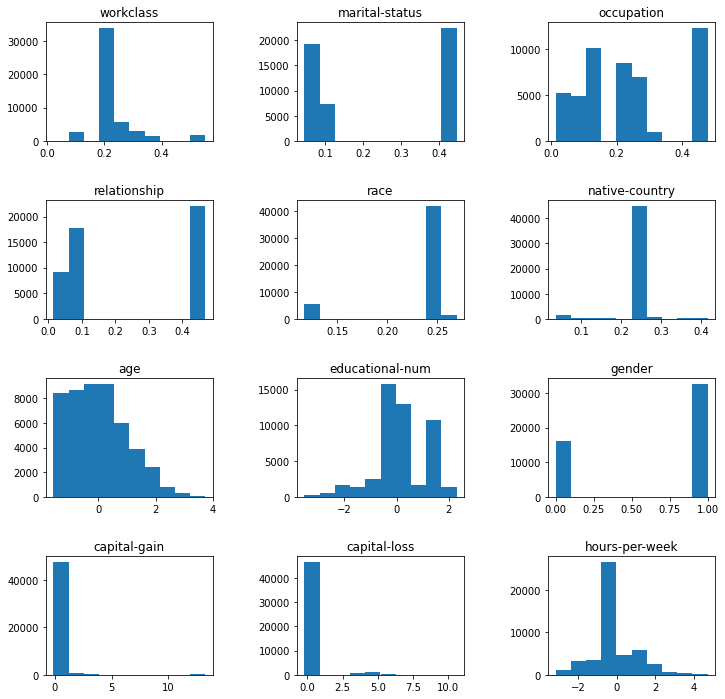

In [36]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(4, 3, 1)
plt.title('workclass')
plt.hist(data['workclass'])
plt.subplot(4, 3, 2)
plt.title('marital-status')
plt.hist(data['marital-status'])
plt.subplot(4, 3, 3)
plt.title('occupation')
plt.hist(data['occupation'])
plt.subplot(4, 3, 4)
plt.title('relationship')
plt.hist(data['relationship'])
plt.subplot(4, 3, 5)
plt.title('race')
plt.hist(data['race'])
plt.subplot(4, 3, 6)
plt.title('native-country')
plt.hist(data['native-country'])
plt.subplot(4, 3, 7)
plt.title('age')
plt.hist(data['age'])
plt.subplot(4, 3, 8)
plt.title('educational-num')
plt.hist(data['educational-num'])
plt.subplot(4, 3, 9)
plt.title('gender')
plt.hist(data['gender'])
plt.subplot(4, 3, 10)
plt.title('capital-gain')
plt.hist(data['capital-gain'])
plt.subplot(4, 3, 11)
plt.title('capital-loss')
plt.hist(data['capital-loss'])
plt.subplot(4, 3, 12)
plt.title('hours-per-week')
plt.hist(data['hours-per-week'])

plt.show

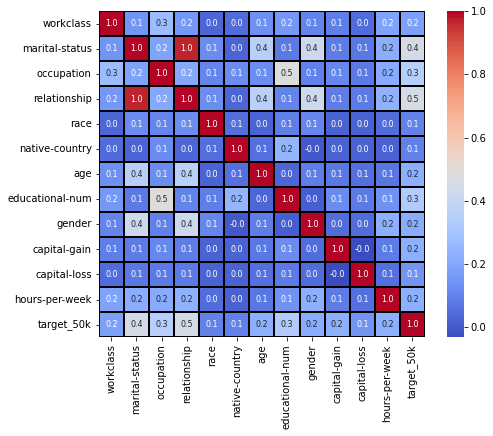

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), cmap= 'coolwarm', linewidths=1, fmt='.1f', annot=True, linecolor='black', square=True, annot_kws={'size':8})
plt.show()

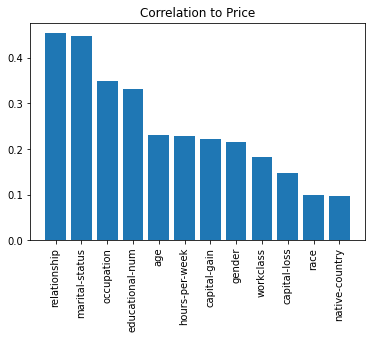

In [38]:
corrmat = data.loc[:].corrwith(
    data['target_50k']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

## 5. Моделирование<a class='anchor' id='models'>

In [39]:
results_all = {}

In [40]:
features = list(data)[:12]
target = list(data)[12]

In [41]:
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [42]:
log_regr = LogisticRegression(random_state = 42)
adaboost = AdaBoostClassifier(n_estimators=100)
gboost = GradientBoostingClassifier(n_estimators=100)
rand_forrest = RandomForestClassifier(n_estimators=25)
d_tree = DecisionTreeClassifier(max_depth=5)
mlp_class = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

In [43]:
mlp_class.fit(X_train, y_train)
preds_mlp_class = mlp_class.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_mlp_class)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['mlp_class'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                           roc_auc_score(y_test, preds_mlp_class), r2(y_test, preds_mlp_class)]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [44]:
log_regr.fit(X_train, y_train)

preds_log_regr = log_regr.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_log_regr)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['log_regr'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                           roc_auc_score(y_test, preds_log_regr), r2(y_test, preds_log_regr)]

In [45]:
adaboost.fit(X_train, y_train)

preds_adaboost = adaboost.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_adaboost)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['adaboost'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                           roc_auc_score(y_test, preds_adaboost), r2(y_test, preds_log_regr)]

In [46]:
gboost.fit(X_train, y_train)

preds_gboost = gboost.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_gboost)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['gboost'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                         roc_auc_score(y_test, preds_gboost), r2(y_test, preds_log_regr)]

In [47]:
rand_forrest.fit(X_train, y_train)

preds_rand_forrest = rand_forrest.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_rand_forrest)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['rand_forrest'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                               roc_auc_score(y_test, preds_rand_forrest), r2(y_test, preds_log_regr)]

In [48]:
d_tree.fit(X_train, y_train)

preds_d_tree = rand_forrest.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_d_tree)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['d_tree'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                         roc_auc_score(y_test, preds_d_tree), r2(y_test, preds_log_regr)]

In [49]:
def results(data_res):
    df = pd.DataFrame(data_res).T
    df.columns=['Best Threshold', 'F-Score', 'Precision', 'Recall', 'roc_auc_score', 'R_2']
    return df

In [50]:
results(results_all)

,Best Threshold,F-Score,Precision,Recall,roc_auc_score,R_2
mlp_class,0.340570,0.687507,0.617665,0.775157,0.906324,0.435559
log_regr,0.306048,0.674246,0.604913,0.761530,0.899577,0.414067
adaboost,0.498318,0.706998,0.652270,0.771751,0.917647,0.414067
gboost,0.377413,0.714066,0.698496,0.730346,0.920554,0.414067
rand_forrest,0.382667,0.678806,0.643646,0.718029,0.890522,0.414067
d_tree,0.382667,0.678806,0.643646,0.718029,0.890522,0.414067


**Вывод**

Выбираем gboost

## 6. Pipeline<a class='anchor' id='pipeline'>

In [52]:
#загружаем наш исходник
data = '/home/Dataset.data'
df = pd.read_csv(data, sep=' ')

In [53]:
#сразу делаем валидационную выборку с исходника, которую будем потом проверять по пайплайну
df_valid = df.sample(frac=0.65)

df_valid_x = df_valid.iloc[:,:-1]
df_valid_y = df_valid.iloc[:,-1]

df_valid_x.to_csv('df_valid_x.csv', index=None)
df_valid_y.to_csv('df_valid_y.csv', index=None)

In [54]:
df_valid.head()

,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0.1,40,United-States,<=50K
37802,35,Private,194809,11th,7,Divorced,Machine-op-inspct,Unmarried,White,Female,0,0,40,United-States,<=50K
35429,22,Private,138513,Some-college,10,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
35894,46,Private,194431,HS-grad,9,Never-married,Tech-support,Other-relative,White,Male,0,0,40,United-States,<=50K
106,28,Private,154236,HS-grad,9,Never-married,Transport-moving,Own-child,White,Male,2597,0,40,United-States,<=50K
32090,39,Private,236391,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,<=50K


In [55]:
#обработка признаков в пайплайне 

class DFProcessing(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.columns=["age", "workclass", "fnlwgt", "education", "educational-num", "marital-status", "occupation", "relationship", 
            "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country"]

        # пол
        X.loc[(X['gender'] == 'Male'), 'gender'] = 1
        X.loc[(X['gender'] == 'Female'), 'gender'] = 0
        X['gender'] = X['gender'].astype(np.float32)
        
        # text
        X_cbe = cbe_encoder.transform(X[["workclass", "marital-status", "occupation", "relationship", "race", "native-country"]])
        
        # data_itog
        X_data = X_cbe.join(X[["age", "educational-num", "gender", "capital-gain", 
                     "capital-loss", "hours-per-week"]])
        
        X_data[['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.fit_transform(X_data[['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']])
        
        return X_data


In [56]:
steps = [('transformfeatures', DFProcessing()), ('gboost', gboost)]
pipeline = Pipeline(steps)

In [57]:
predictions = pipeline.predict_proba(df_valid_x)
pd.DataFrame({'preds': predictions[:, 1]}).to_csv("test_predictions.csv", index=None)

In [58]:
#проверка трансормации пайплайна
data_check = pipeline[0].transform(df_valid_x)

In [59]:
data_check.head()

,workclass,marital-status,occupation,relationship,race,native-country,age,educational-num,gender,capital-gain,capital-loss,hours-per-week
37802,0.217874,0.101182,0.123176,0.060328,0.253987,0.243982,-0.268162,-1.194337,0.0,-0.145632,-0.2139,-0.037106
35429,0.217874,0.045495,0.226278,0.014673,0.253987,0.243982,-1.213241,-0.029011,1.0,-0.145632,-0.2139,-0.037106
35894,0.217874,0.045495,0.290421,0.034664,0.253987,0.243982,0.531520,-0.417453,1.0,-0.145632,-0.2139,-0.037106
106,0.217874,0.045495,0.204261,0.014673,0.253987,0.243982,-0.777051,-0.417453,1.0,0.204346,-0.2139,-0.037106
32090,0.217874,0.446123,0.226278,0.448661,0.253987,0.243982,0.022631,-0.417453,1.0,-0.145632,-0.2139,0.366402


In [60]:
roc_auc_score(y_score=predictions[:, 1][:], y_true=df_valid_y)

0.9214500456561487

In [61]:
with open("gboost_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

## 7. Проверка Pipeline<a class='anchor' id='check'>

In [62]:
with open('gboost_pipeline.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [65]:
data = '/home/Dataset.data'
df = pd.read_csv(data, sep=' ')

df_valid = df.sample(frac=0.5)

df_valid_x = df_valid.iloc[:,:-1]
df_valid_y = df_valid.iloc[:,-1]

In [66]:
predictions = pipeline.predict_proba(df_valid_x)
pd.DataFrame({'preds': predictions[:, 1]}).to_csv("test_predictions.csv", index=None)

In [67]:
roc_auc_score(y_score=predictions[:, 1][:], y_true=df_valid_y)

0.9234552611795879

In [68]:
df_valid_x.head(1)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
40482,29,State-gov,67053,HS-grad,9,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,1.0,0,0,40,Thailand


In [69]:
pipeline[0].transform(df_valid_x).head(1)

,workclass,marital-status,occupation,relationship,race,native-country,age,educational-num,gender,capital-gain,capital-loss,hours-per-week
40482,0.267527,0.045495,0.041478,0.101418,0.269236,0.169009,-0.698872,-0.420332,1.0,-0.144609,-0.218342,-0.030876


## 8. Проверка API Pipeline<a class='anchor' id='apicheck'>

In [70]:
import requests

import urllib.request
import json 

In [71]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify

In [75]:
import dill
dill._dill._reverse_typemap['ClassType'] = type

In [79]:
path='/home/'
path2='/content/'

In [78]:
with open(path + 'gboost_pipeline.dill', 'rb') as in_strm:
    model = dill.load(in_strm)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator DummyClassifier from version 1.0 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 1.0 when using version 1.0.1. This might lead to breaking code or invalid results. Use a

In [80]:
X_valid = pd.read_csv(path2+"df_valid_x.csv")
y_valid = pd.read_csv(path2+"df_valid_y.csv")

In [ ]:
# Обработчики и запуск Flask
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route('/predict', methods=['GET', 'POST'])
def predict():
  data = {"success": False}
  # ensure an image was properly uploaded to our endpoint
  if request.method == "POST":
      description, company_profile, benefits = "", "", "qq"
      request_json = request.get_json()
  if request_json["description"]:
      description = request_json['description']
  
  if request_json["company_profile"]:
      company_profile = request_json['company_profile']
		       
  if request_json["benefits"]:
      benefits = request_json['benefits']
  print(description )  
  preds = model.predict_proba(pd.DataFrame({"description": [description],
                                            "company_profile": [company_profile],
                                            "benefits": [benefits]}))
  data["predictions"] = preds[:, 1][0]
  data["description"] = description
	# indicate that the request was a success
  data["success"] = True

	# return the data dictionary as a JSON response
  return jsonify(data)


if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7a74-35-229-61-96.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


In [ ]:
# Пример данных
data_valid = ('34', 'Private', '226443', 'HS-grad', '9', 'Divorced', 'Adm-clerical', 'Own-child', 'White', '1.0', '0', '0', '40', 'United-States')

# формируем запрос
def send_json(x):
    age, workclass, fnlwgt, education, educational_num, marital_status, occupation, relationship, race, gender, capital_gain, capital_loss, hours_per_week, native_country = x
    body = {'age': age, 'workclass': workclass, 'fnlwgt': fnlwgt, 
            'education': education, 'educational-num': educational_num, 'marital-status': marital_status, 
            'occupation': occupation, 'relationship': relationship, 'race': race, 'gender': gender, 
           'capital-gain': capital_gain, 'capital-loss': capital_loss, 'hours-per-week': hours_per_week, 
            'native-country': native_country} 

    myurl = 'http://7a74-35-229-61-96.ngrok.io'+'predict'
    headers = {'content-type': 'application/json; charset=utf-8'}
    response = requests.post(myurl, json=body, headers=headers)
    return response.json()['predictions']

# обращение к серверу с запросом из одного набора (его построили руками выше - data)
if __name__ == '__main__':
    response = send_json(data_valid)
    print('предсказание',response)